In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import holidays

from neuralprophet import NeuralProphet
from prophet import Prophet
from prophet.serialize import model_to_json
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

import sys
import os

backend_path = os.path.abspath('../backend')
sys.path.append(backend_path)
from get_metrics import get_metrics

# Количество предсказанных дней
pred_days_forecast = 180

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [2]:
# Чтение DataFrame df в файл data/df.csv
df = pd.read_csv('../data/df.csv')

# Чтение DataFrame df_train в файл data/df_train.csv
df_train = pd.read_csv('../data/df_train.csv')

# Чтение DataFrame df_test в файл data/df_test.csv
df_test = pd.read_csv('../data/df_test.csv')

In [3]:
# Преобразование столбца ds в формат datetime
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d', dayfirst=True)
df_train['ds'] = pd.to_datetime(df_train['ds'], format='%Y-%m-%d', dayfirst=True)
df_test['ds'] = pd.to_datetime(df_test['ds'], format='%Y-%m-%d', dayfirst=True)

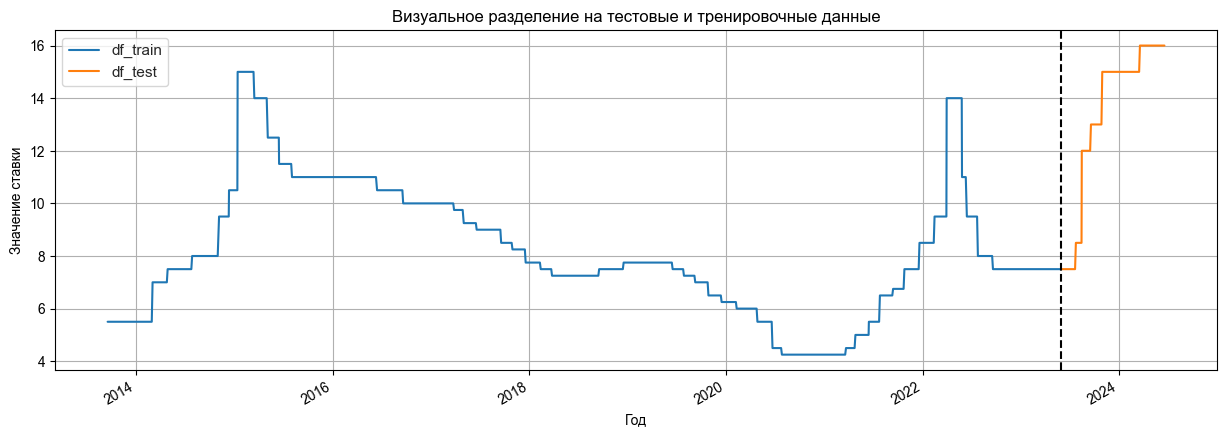

In [4]:
# Отображаем график с разделением train, test для наглядности
fig, ax = plt.subplots(figsize = (10, 5))

sns.set_theme(style="whitegrid", palette="Accent")

fig.set_figheight(5)
fig.set_figwidth(15)
df_train.set_index('ds').plot(ax=ax, label= 'train', title='Визуальное разделение на тестовые и тренировочные данные')
df_test.set_index('ds').plot(ax=ax, label='test')
ax.axvline(df_train['ds'][-1:].values, ls='--', color='black')
ax.legend(['df_train', 'df_test'])
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

# Baseline Prophet on df_train для проверки модели

In [5]:
# Обучение модели на train
model_baseline = Prophet()
model_baseline.fit(df_train)

00:19:40 - cmdstanpy - INFO - Chain [1] start processing
00:19:42 - cmdstanpy - INFO - Chain [1] done processing


In [6]:
# Период, который надо отрезать и предсказать (проверка модели)
pred_days = int(df.shape[0]*0.1)

In [7]:
# Создание df с прогнозом
future = model_baseline.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_baseline.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2674,2024-02-16,10.053160,8.414844,11.676907
2675,2024-02-17,10.589583,8.767393,12.214111
2676,2024-02-18,10.600900,8.983240,12.233969
2677,2024-02-19,10.051279,8.360096,11.678821
2678,2024-02-20,10.082804,8.519181,11.745618


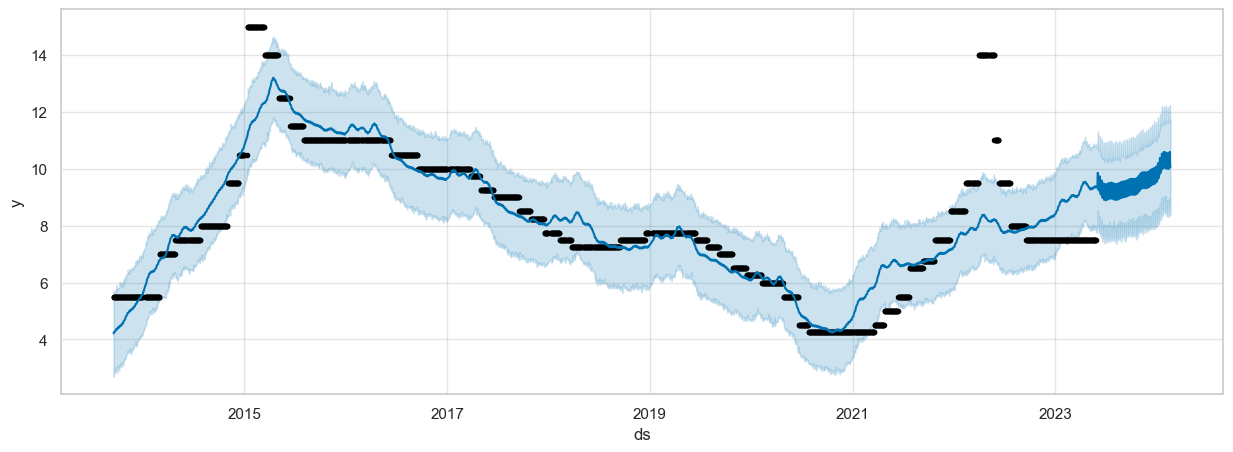

In [8]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_baseline.plot(forecast,ax=ax)
plt.show()

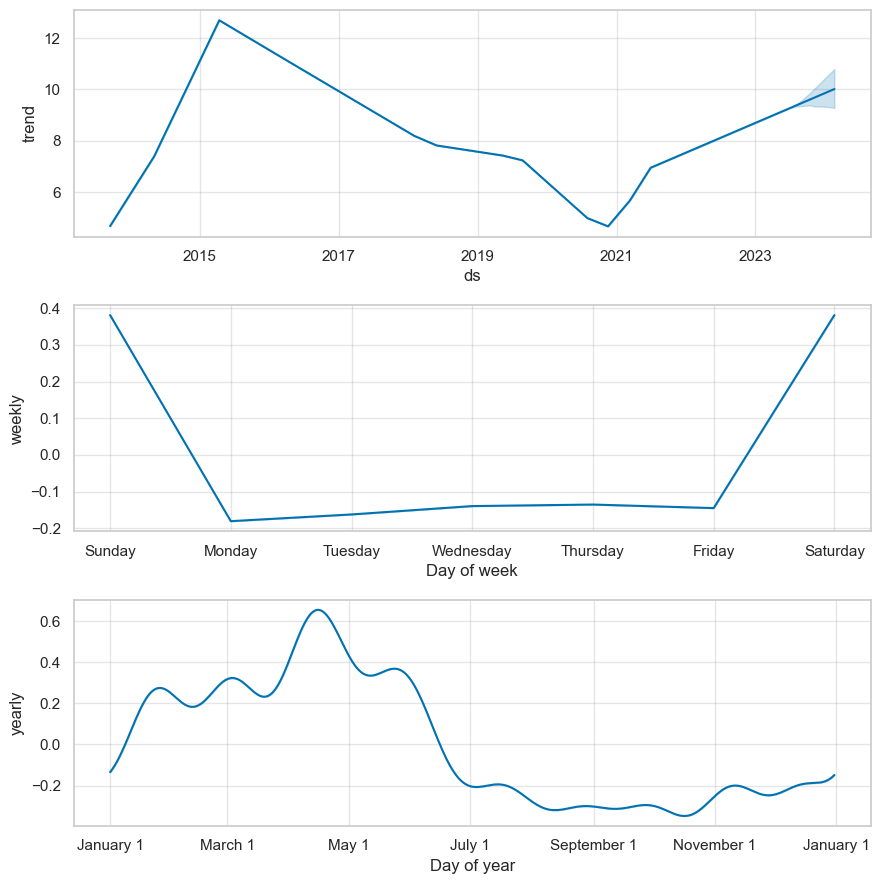

In [9]:
# Смотрим тренд, годовые и сезонные признаки
fig = model_baseline.plot_components(forecast)
plt.show()

## Сравнение фактов и прогнозов

In [10]:
# Создание df с прогнозом
df_test_forecast = model_baseline.predict(df_test)
df_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
262,2024-06-10,10.318011,8.346181,12.366412
263,2024-06-11,10.315328,8.438006,12.394190
264,2024-06-13,10.300212,8.364115,12.461512
265,2024-06-14,10.269837,8.316624,12.419464
266,2024-06-17,10.175580,8.178013,12.341583


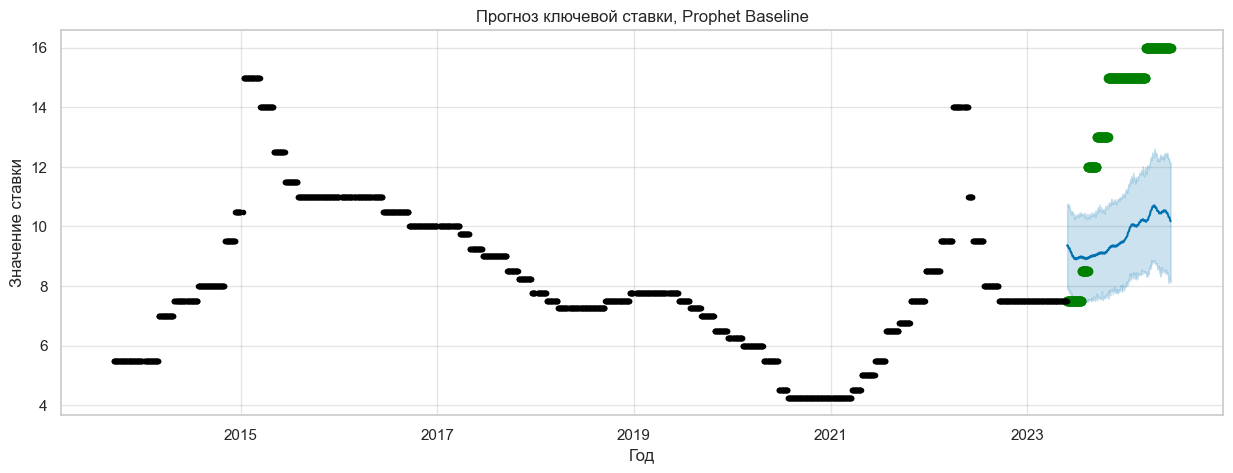

In [11]:
# Смотрим совпадение фактического курса с предсказанным курсом prophet baseline обученным на train
fig, ax = plt.subplots(figsize= (10, 5))

fig.set_figheight(5)
fig.set_figwidth(15)
predict = model_baseline.predict(df_test)
fig = model_baseline.plot(predict, ax=ax)
ax.scatter(df_test.ds, df_test['y'], color = 'g')
ax.set_title('Прогноз ключевой ставки, Prophet Baseline')
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

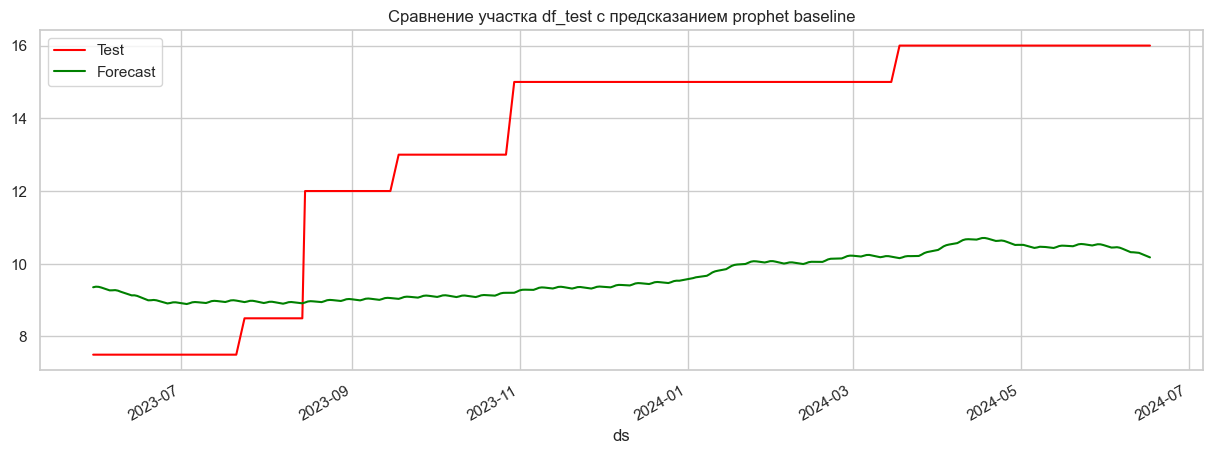

In [12]:
# Сравнение участка df_test с предсказанием prophet baseline
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet baseline')
plt.show()

In [13]:
# Просмотр метрик модели обученной на train
metrics = get_metrics(y_test=df_test['y'], y_pred=df_test_forecast['yhat'], name='Prophet_baseline')
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,4.155639,0.296686,20.135715,4.487284


Из приведенного выше графика мы видим, что существует разрыв в прогнозах и фактических данных. Поэтому нам нужно оптимизировать модель, добавив другие параметры, напрмиер, такие как праздники

# Prophet with holidays

In [14]:
# Создаем df праздников в РФ начиная с 2013 по сегодня
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Russia(years=[2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024]).items()):
    new_row = pd.DataFrame({'ds': date, 'holiday': "RU-Holidays"}, index=[0])
    holiday = pd.concat([holiday, new_row], ignore_index=True)  

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [15]:
# Тренировка модели с праздниками
model_with_holidays = Prophet(holidays=holiday)
model_with_holidays.fit(df_train)

00:19:50 - cmdstanpy - INFO - Chain [1] start processing
00:19:51 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
# Создание df с прогнозом
future = model_with_holidays.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_with_holidays.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2674,2024-02-16,10.056937,8.443197,11.542918
2675,2024-02-17,10.559178,8.826694,12.230868
2676,2024-02-18,10.570519,8.911690,12.139704
2677,2024-02-19,10.054367,8.543266,11.666277
2678,2024-02-20,10.085629,8.412994,11.719244


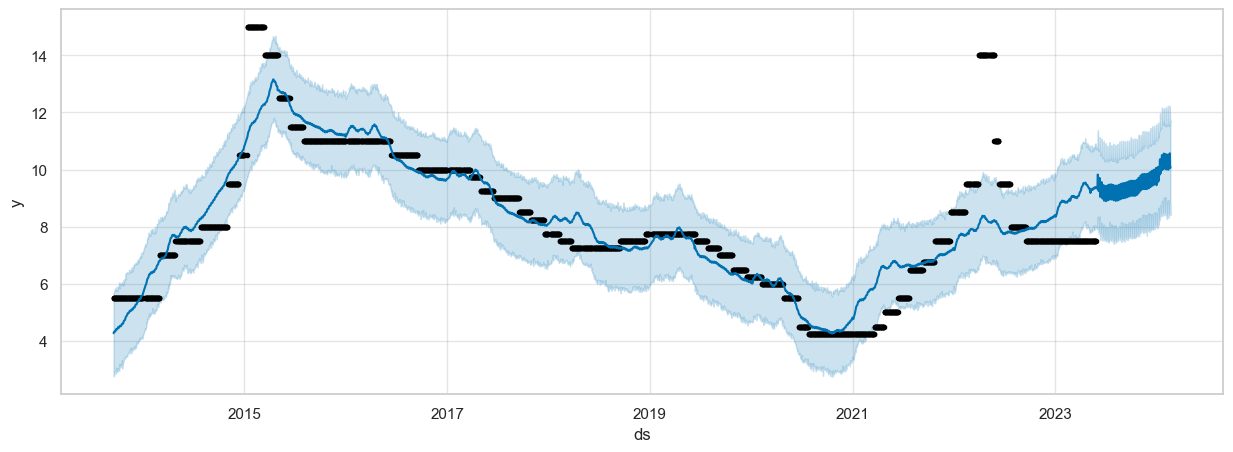

In [17]:
# Смотрим график прогноза с праздниками
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_with_holidays.plot(forecast,ax=ax)
plt.show()

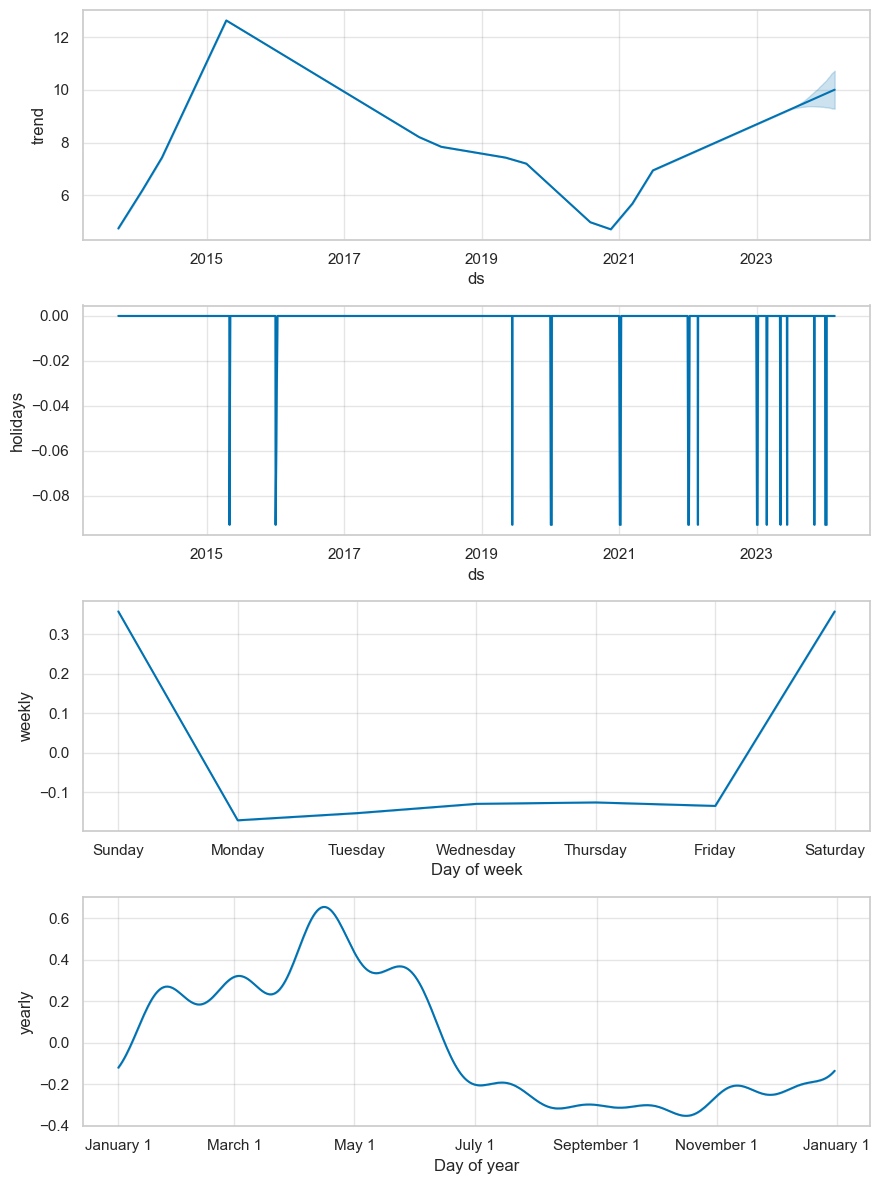

In [18]:
# Смотрим тренд, годовые и сезонные признаки обученной модели с праздниками
fig = model_with_holidays.plot_components(forecast)
plt.show()

## Сравнение фактов и прогнозов

In [19]:
# Создание df с прогнозом
df_test_forecast_holiday = model_with_holidays.predict(df_test)
df_test_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
262,2024-06-10,10.320881,8.292848,12.425492
263,2024-06-11,10.318048,8.425396,12.264759
264,2024-06-13,10.302900,8.407968,12.223461
265,2024-06-14,10.273300,8.259781,12.223848
266,2024-06-17,10.178030,8.286706,12.247864


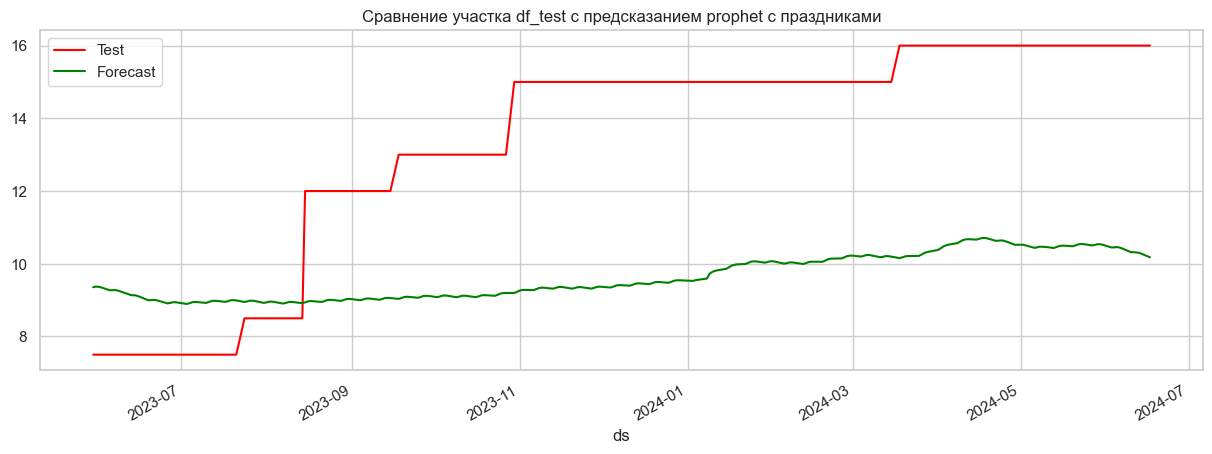

In [20]:
# Сравнение участка df_test с предсказанием prophet_with_holidays
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet с праздниками')
plt.show()

In [21]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_holiday['yhat'], name='Prophet_with_holidays')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,4.155639,0.296686,20.135715,4.487284
0,Prophet_with_holidays,4.157464,0.296846,20.150442,4.488924


Из метрик и графиков видим, что модель с праздниками показывает результаты немного изменились.

# Тюнинг тест модели

In [22]:
# Создание сетки параметров и подсчёт количества вариаций обучения
params_grid = {
    'changepoint_prior_scale': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.3, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1, 10], 
    'holidays_prior_scale': [0.01, 0.1, 1, 10],
    'seasonality_mode': ('multiplicative','additive')
}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt + 1

print('Количество моделей для обучения по сетке:', cnt)

Количество моделей для обучения по сетке: 672


In [23]:
"""Обучение тестовой модели по сетке параметров на df_train"""
# Создаем пустой DataFrame для сохранения метрик и параметров
model_grid_metrics = pd.DataFrame()
model_grid_parameters = pd.DataFrame(columns = ['Parameters'])

# Проходимся по сетке гиперпараметров
for p in tqdm(grid):
    
    # Обучаем Prophet по сетке гиперпараметров
    model_grid = Prophet(
        changepoint_prior_scale = p['changepoint_prior_scale'],
        seasonality_prior_scale = p['seasonality_prior_scale'],
        holidays_prior_scale = p['holidays_prior_scale'],
        seasonality_mode = p['seasonality_mode'],
        #changepoint_range = p['changepoint_range'],
        #holidays=holiday,
    )

    # Добавляем праздники в модель
    #model_grid.add_country_holidays(country_name='RU')

    # Обучаем модель
    model_grid.fit(df_train)

    # Создаем фрейм данных для предсказаний
    model_grid_future = model_grid.make_future_dataframe(periods=pred_days, freq='D', include_history=False)

    # Делаем предсказания
    model_grid_forecast = model_grid.predict(model_grid_future)

    # Вычисляем метрики и добавляем новую строку в df
    model_grid_metrics = pd.concat([model_grid_metrics, get_metrics(y_test=df_test['y'], y_pred=model_grid_forecast['yhat'], name='Prophet_with_grid ')])
    model_grid_parameters = pd.concat([model_grid_parameters, pd.DataFrame({'Parameters': [p]})], ignore_index=True)


  0%|          | 0/672 [00:00<?, ?it/s]00:19:57 - cmdstanpy - INFO - Chain [1] start processing
00:19:58 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/672 [00:01<14:24,  1.29s/it]00:19:58 - cmdstanpy - INFO - Chain [1] start processing
00:19:59 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 2/672 [00:02<12:00,  1.07s/it]00:19:59 - cmdstanpy - INFO - Chain [1] start processing
00:19:59 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 3/672 [00:03<11:04,  1.01it/s]00:20:00 - cmdstanpy - INFO - Chain [1] start processing
00:20:00 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 4/672 [00:04<11:12,  1.01s/it]00:20:01 - cmdstanpy - INFO - Chain [1] start processing
00:20:01 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 5/672 [00:05<11:01,  1.01it/s]00:20:02 - cmdstanpy - INFO - Chain [1] start processing
00:20:02 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 6/672 [00:06<10:42,  1.04it/s]0

In [24]:
# Сброс индексов для будущего объединения с df параметров сетки
model_grid_metrics = model_grid_metrics.reset_index(drop=True)

In [25]:
# Объединение DataFrame по столбцам
metrics_parameters_with_grid = pd.concat([model_grid_metrics, model_grid_parameters], axis=1)
metrics_parameters_with_grid

,model,MAE,MAPE_%,MSE,RMSE,Parameters
0,Prophet_with_grid,6.754940,0.468711,55.503063,7.450038,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
1,Prophet_with_grid,7.091253,0.494215,60.684301,7.790013,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
2,Prophet_with_grid,7.206439,0.503245,62.415040,7.900319,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
3,Prophet_with_grid,7.143498,0.498335,61.463229,7.839849,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
4,Prophet_with_grid,6.627117,0.457683,54.032283,7.350666,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
...,...,...,...,...,...,...
667,Prophet_with_grid,12.311292,0.921023,262.805639,16.211281,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
668,Prophet_with_grid,5.220504,0.361666,33.501784,5.788073,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
669,Prophet_with_grid,5.290302,0.366392,34.385650,5.863928,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
670,Prophet_with_grid,5.347688,0.370054,35.170326,5.930457,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."


In [26]:
# Сортировка по метрике
metrics_parameters_with_grid = metrics_parameters_with_grid.sort_values(by=['MAE'])
metrics_parameters_with_grid = metrics_parameters_with_grid.reset_index(drop=True)
metrics_parameters_with_grid.head()

,model,MAE,MAPE_%,MSE,RMSE,Parameters
0,Prophet_with_grid,4.068097,0.296869,18.792035,4.334978,"{'changepoint_prior_scale': 0.03, 'holidays_pr..."
1,Prophet_with_grid,4.068097,0.296869,18.792035,4.334978,"{'changepoint_prior_scale': 0.03, 'holidays_pr..."
2,Prophet_with_grid,4.068097,0.296869,18.792035,4.334978,"{'changepoint_prior_scale': 0.03, 'holidays_pr..."
3,Prophet_with_grid,4.068097,0.296869,18.792035,4.334978,"{'changepoint_prior_scale': 0.03, 'holidays_pr..."
4,Prophet_with_grid,4.078311,0.297441,18.917500,4.349425,"{'changepoint_prior_scale': 0.03, 'holidays_pr..."


## Лучшие параметры после обучения по сетке

In [27]:
# Сохранение в переменную лучших параметров после обучения по сетке
best_params = metrics_parameters_with_grid['Parameters'][0]

# Просмотр лучших параметров
best_params

{'changepoint_prior_scale': 0.03,
 'holidays_prior_scale': 1,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 1}

In [28]:
# Обучение модели на лучших параметрах
final_test_model = Prophet(**best_params)
final_test_model.fit(df_train)

00:36:52 - cmdstanpy - INFO - Chain [1] start processing
00:36:53 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
# Создание df с прогнозом
future = final_test_model.make_future_dataframe(periods=pred_days, freq='D')
forecast = final_test_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2674,2024-02-16,10.672213,9.086578,12.212233
2675,2024-02-17,11.231862,9.626720,12.779915
2676,2024-02-18,11.244219,9.653130,12.867214
2677,2024-02-19,10.670277,9.068126,12.254662
2678,2024-02-20,10.705353,9.106313,12.271246


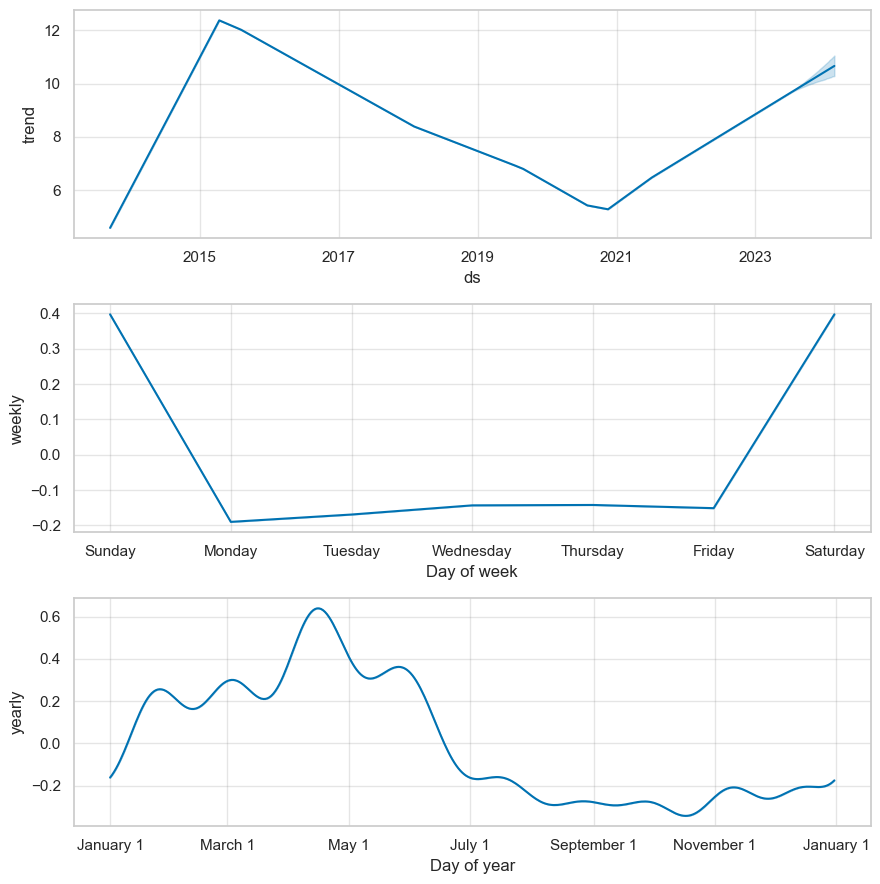

In [30]:
# Смотрим тренд, годовые и сезонные признаки
fig = final_test_model.plot_components(forecast)

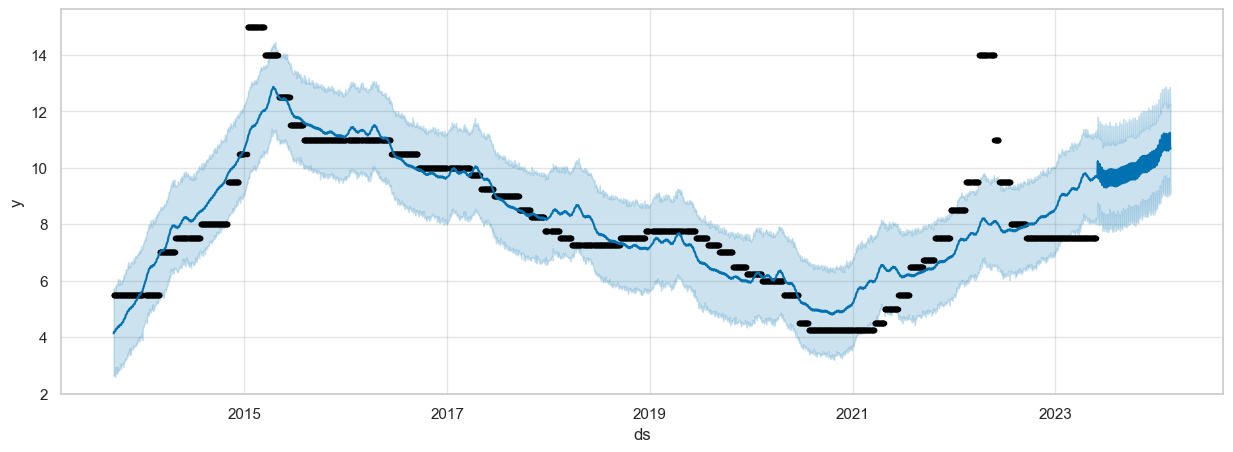

In [31]:
# Смотрим график прогноза после обучния на лучших параметрах
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = final_test_model.plot(forecast,ax=ax)
plt.show()

## Сравнение фактов и прогнозов

In [32]:
# Создание df с прогнозом
df_test_forecast_final = final_test_model.predict(df_test)
df_test_forecast_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
262,2024-06-10,11.133591,9.517788,12.815037
263,2024-06-11,11.136188,9.450884,12.781448
264,2024-06-13,11.126000,9.454207,12.781025
265,2024-06-14,11.098270,9.271684,12.739321
266,2024-06-17,11.005677,9.239616,12.597802


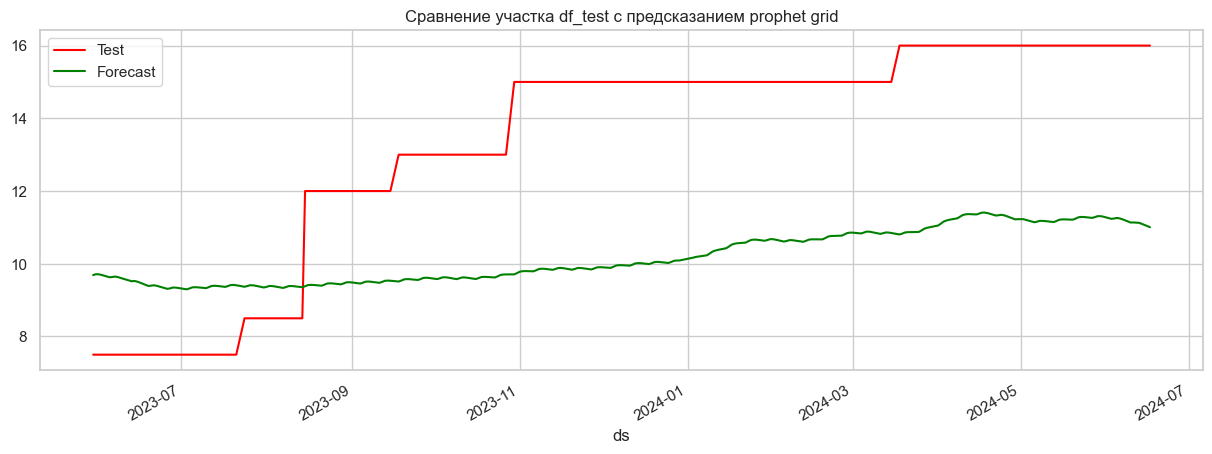

In [33]:
# Сравнение участка df_test с предсказанием prophet grid
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet grid')
plt.show()

In [34]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_final['yhat'], name='Prophet_with_grid')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,4.155639,0.296686,20.135715,4.487284
0,Prophet_with_holidays,4.157464,0.296846,20.150442,4.488924
0,Prophet_with_grid,3.765006,0.275163,15.933341,3.991659


In [35]:
# Сохранение модели в JSON файл
with open('../models/final_test_model.json', 'w') as fout:
    fout.write(model_to_json(final_test_model))

# Baseline NeuralProphet on df_train для проверки модели

In [36]:
# Обучение модели на df
NeuralProphet_bl = NeuralProphet()
NeuralProphet_bl.set_plotting_backend("plotly-static")
metricsnp = NeuralProphet_bl.fit(df_train)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.139% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (38) is too small than the required number                     for the learning rate finder (235). The results might not be optimal.


Finding best initial lr:   0%|          | 0/235 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [37]:
# Создание df с прогнозом
future_np_bl = NeuralProphet_bl.make_future_dataframe(df_train, periods = pred_days, n_historic_predictions = True)
forecast_np_bl = NeuralProphet_bl.predict(df_test)
forecast_np_bl.tail()

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.139% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.004% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.004% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B


Predicting: 38it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_yearly,season_weekly
262,2024-06-10,16.0,11.314830,9.672831,0.275623,1.366377
263,2024-06-11,16.0,11.321900,9.677597,0.274508,1.369796
264,2024-06-13,16.0,11.348354,9.687130,0.270133,1.391091
265,2024-06-14,16.0,11.334124,9.691896,0.266885,1.375342
266,2024-06-17,16.0,11.322891,9.706196,0.253048,1.363647


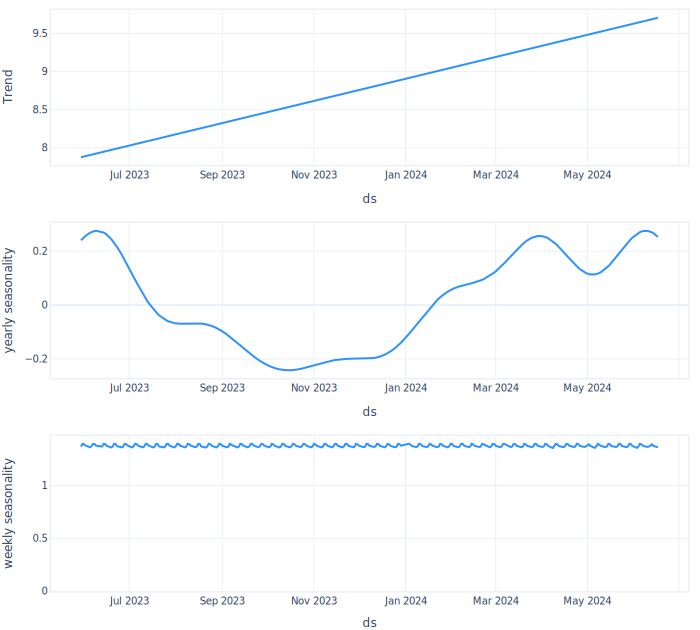

In [38]:
# Смотрим тренд, годовые и сезонные признаки
NeuralProphet_bl.plot_components(forecast_np_bl)

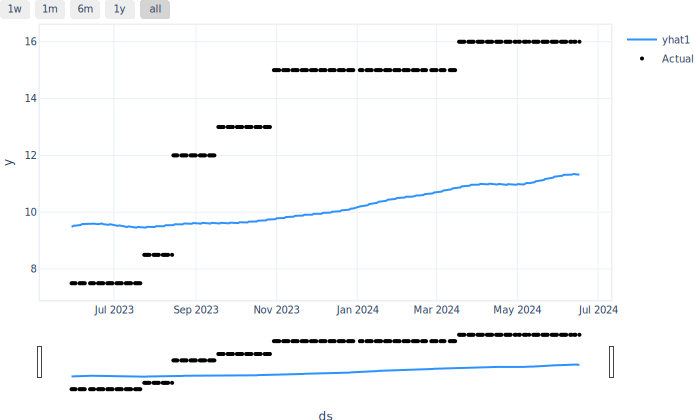

In [39]:
# Смотрим график прогноза после обучения
fig = NeuralProphet_bl.plot(forecast_np_bl, ax=ax)

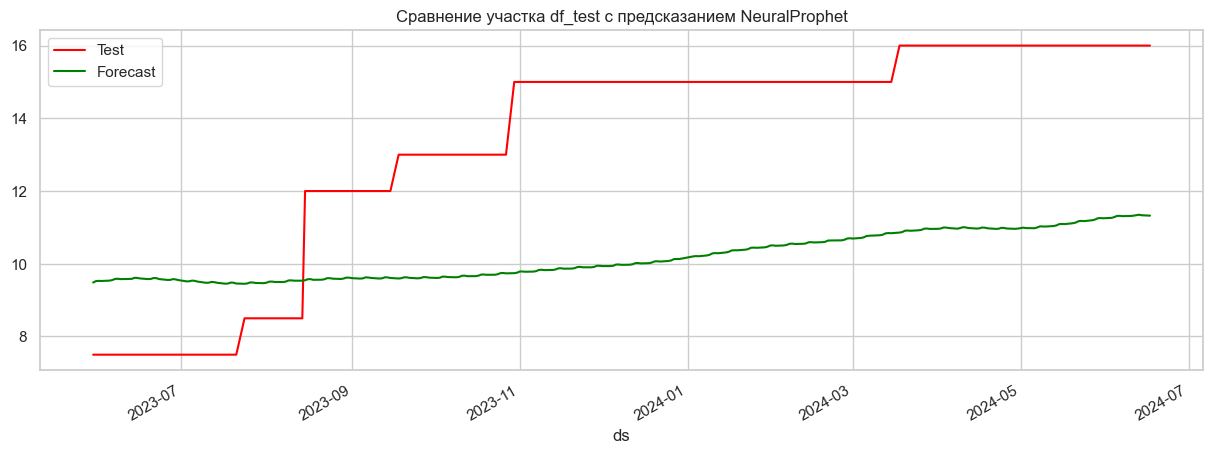

In [40]:
# Сравнение участка df_test с предсказанием prophet grid
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
forecast_np_bl.plot(kind='line',x='ds',y='yhat1', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием NeuralProphet')
plt.show()

In [41]:
# Сравниваем метрики после добавления NeuralProphet
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=forecast_np_bl['yhat1'], name='NeuralProphet')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,4.155639,0.296686,20.135715,4.487284
0,Prophet_with_holidays,4.157464,0.296846,20.150442,4.488924
0,Prophet_with_grid,3.765006,0.275163,15.933341,3.991659
0,NeuralProphet,3.814933,0.279319,16.339073,4.042162


# Обучение и прогнозирование курса ставки рефинансирования ЦБ РФ на df

# Prophet baseline on df

In [42]:
# Обучение модели на df
prophet_bl = Prophet()
prophet_bl.fit(df)

00:37:34 - cmdstanpy - INFO - Chain [1] start processing
00:37:34 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
# Создание df с прогнозом
future_bl = prophet_bl.make_future_dataframe(periods=pred_days_forecast, freq='D')
forecast_bl = prophet_bl.predict(future_bl)
forecast_bl[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2854,2024-12-10,15.485993,13.669657,17.320028
2855,2024-12-11,15.513086,13.796937,17.294176
2856,2024-12-12,15.530055,13.789200,17.410058
2857,2024-12-13,15.528934,13.742124,17.473133
2858,2024-12-14,16.312454,14.516638,18.087174


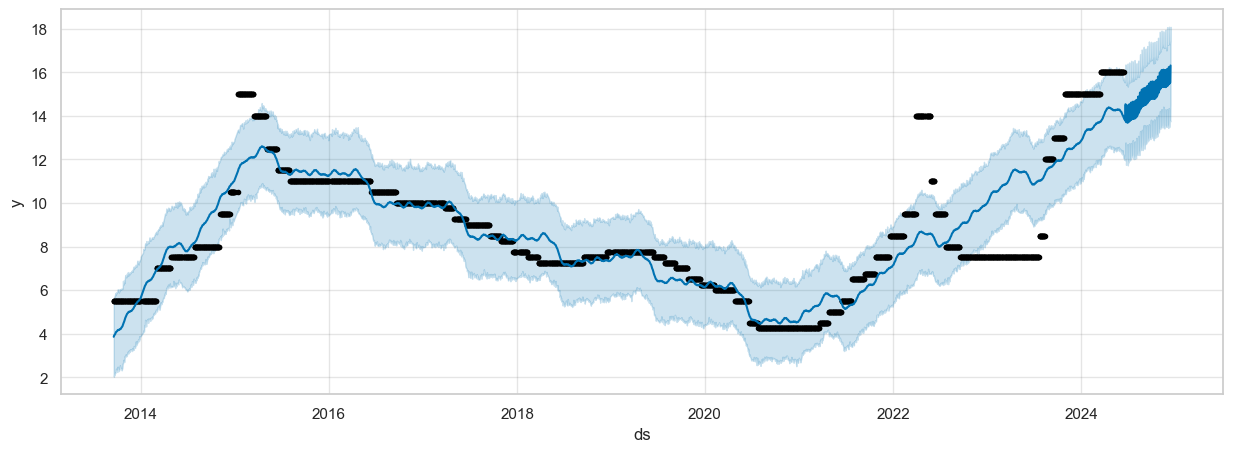

In [44]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = prophet_bl.plot(forecast_bl,ax=ax)
plt.show()

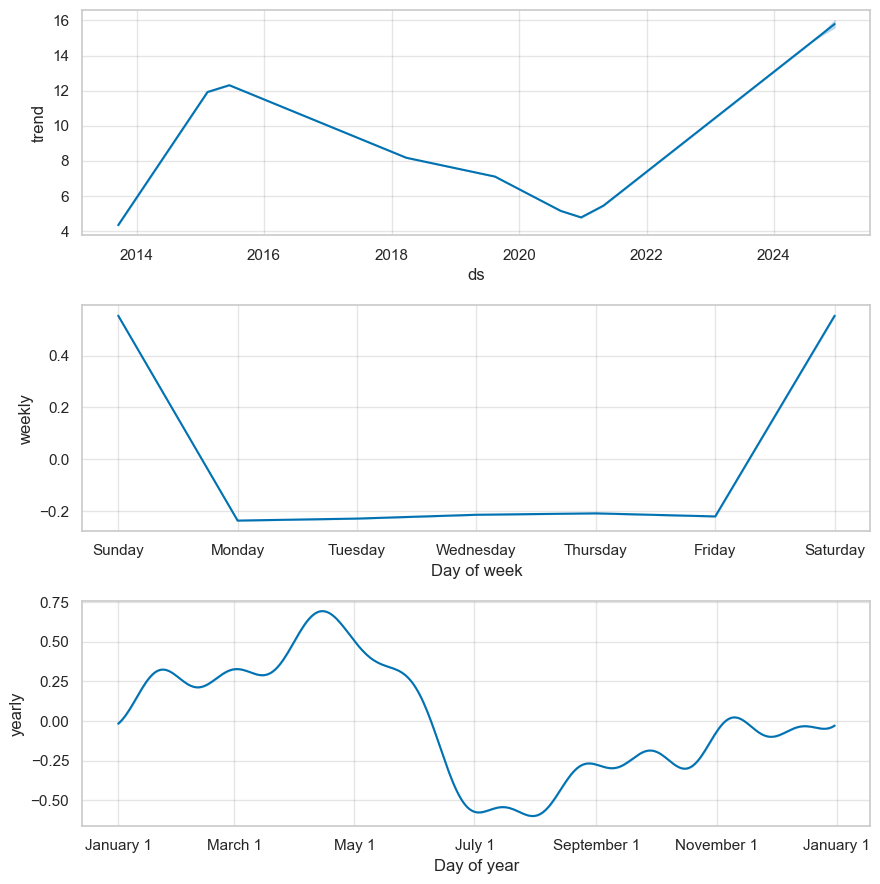

In [45]:
# Смотрим тренд, годовые и сезонные признаки
fig = prophet_bl.plot_components(forecast_bl)
plt.show()

# Prophet best params on df

In [46]:
# Обучение модели на df
final_test_model = Prophet()
final_test_model.fit(df)

00:37:38 - cmdstanpy - INFO - Chain [1] start processing
00:37:39 - cmdstanpy - INFO - Chain [1] done processing


In [47]:
# Создание df с прогнозом
future_ftm = final_test_model.make_future_dataframe(periods=pred_days_forecast, freq='D')
forecast_ftm = final_test_model.predict(future_ftm)
forecast_ftm[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2854,2024-12-10,15.485993,13.605072,17.361266
2855,2024-12-11,15.513086,13.702022,17.307944
2856,2024-12-12,15.530055,13.751579,17.518853
2857,2024-12-13,15.528934,13.728599,17.374199
2858,2024-12-14,16.312454,14.527411,18.151646


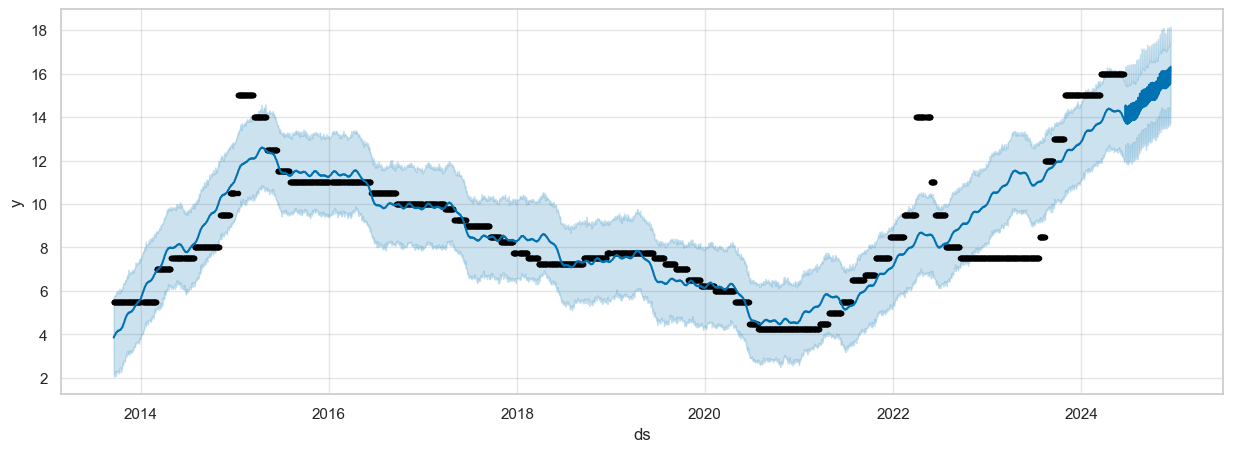

In [48]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = final_test_model.plot(forecast_ftm,ax=ax)
plt.show()

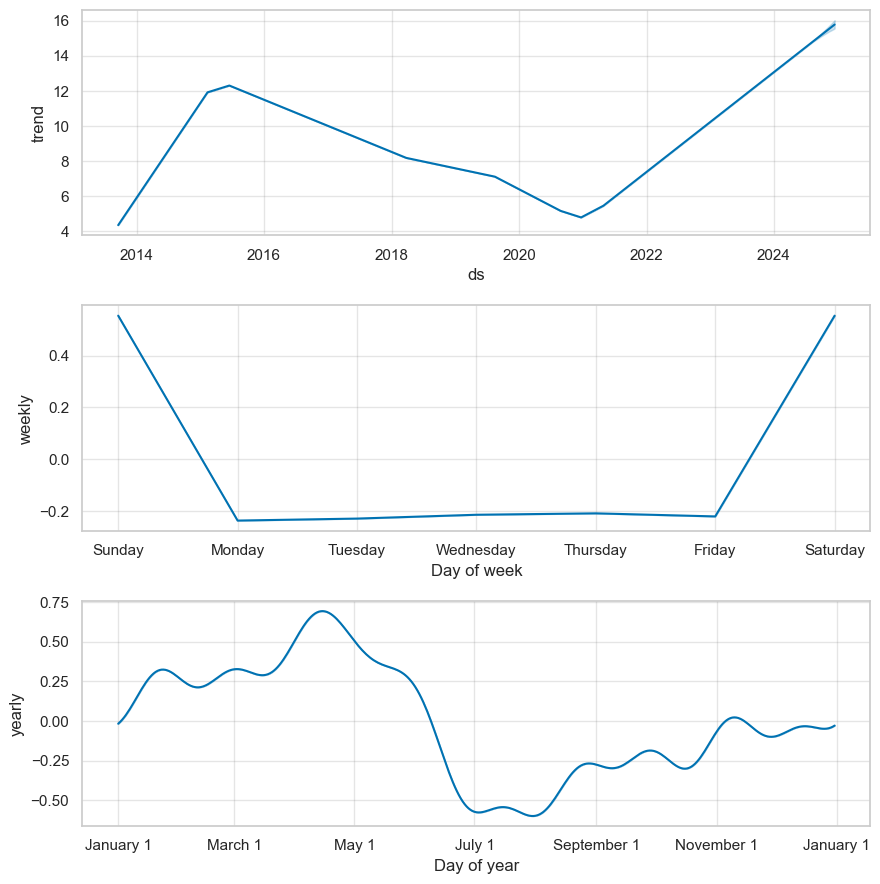

In [49]:
# Смотрим тренд, годовые и сезонные признаки
fig = prophet_bl.plot_components(forecast_ftm)
plt.show()

# NeuralProphet on df

In [50]:
# Обучение модели на df
NeuralProphet_df = NeuralProphet()
NeuralProphet_df.set_plotting_backend("plotly-static")
metricsnp = NeuralProphet_df.fit(df,)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.163% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 80
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (42) is too small than the required number                     for the learning rate finder (236). The results might not be optimal.


Finding best initial lr:   0%|          | 0/236 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [51]:
# Создание df с прогнозом
future_np = NeuralProphet_df.make_future_dataframe(df, periods = pred_days_forecast-104, n_historic_predictions = True)
forecast_np = NeuralProphet_df.predict(future_np)
forecast_np.tail()

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.163% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.241% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.241% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.data.processing._handle_missing_data) - Dropped 76 rows at the end with NaNs in 'y' column.


Predicting: 42it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_yearly,season_weekly
2750,2024-09-25,NaN,15.026153,16.605124,-0.201678,-1.377292
2751,2024-09-26,NaN,15.018063,16.613419,-0.207621,-1.387734
2752,2024-09-27,NaN,15.026871,16.621708,-0.213231,-1.381608
2753,2024-09-30,NaN,15.039527,16.646591,-0.227606,-1.379457
2754,2024-10-01,NaN,15.035162,16.654886,-0.231444,-1.388281


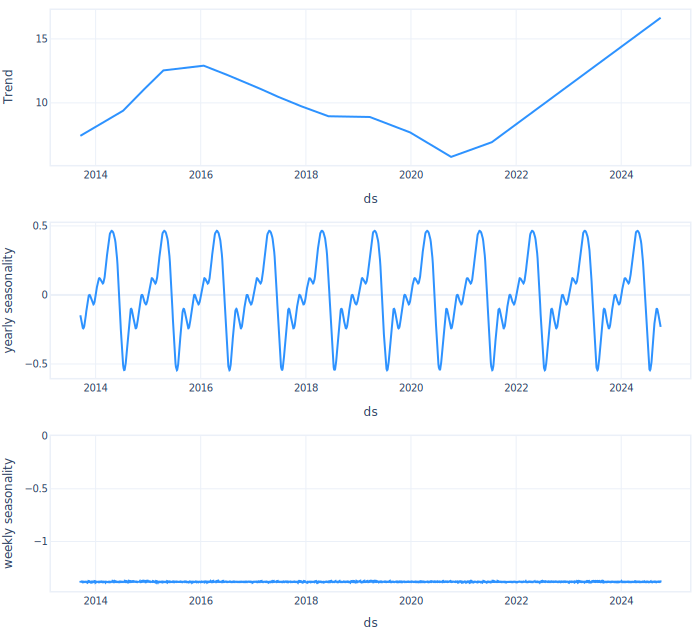

In [52]:
# Смотрим тренд, годовые и сезонные признаки
NeuralProphet_df.plot_components(forecast_np)

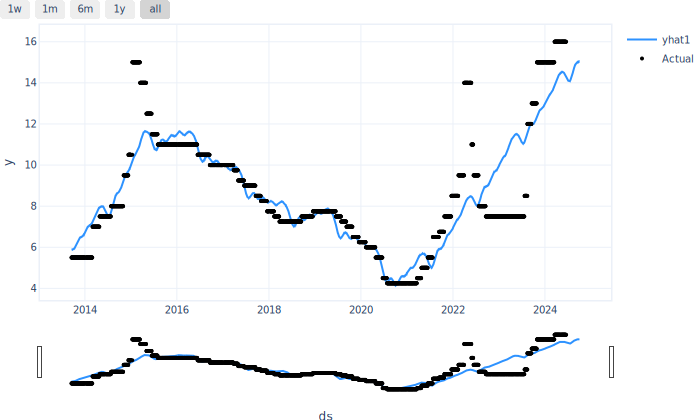

In [53]:
# Смотрим график прогноза
NeuralProphet_df.plot(forecast_np)

# Сравнение прогнозов обученных моделей

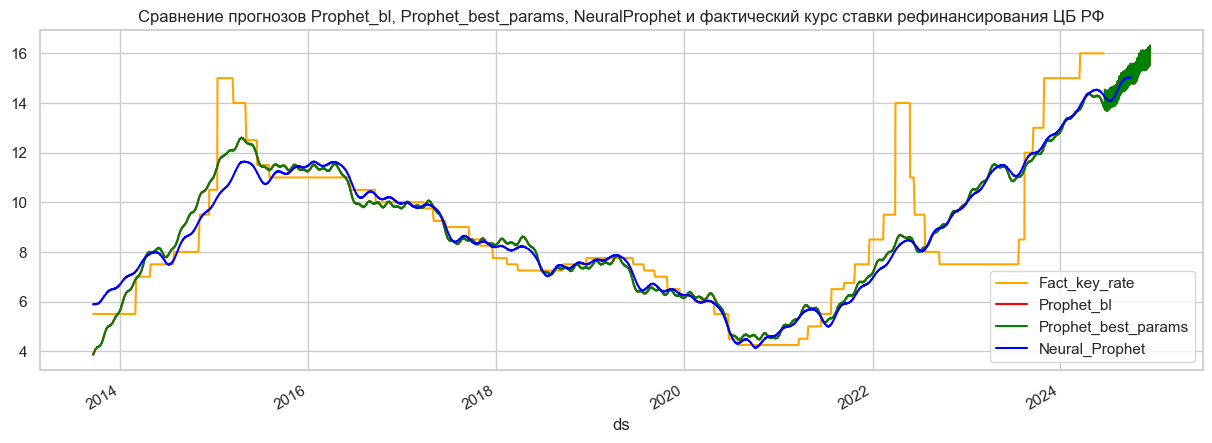

In [54]:
# Сравнение прогнозов Prophet_bl, Prophet_best_params, NeuralProphet и фактический курс ставки рефинансирования ЦБ РФ
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df.plot(kind='line',x='ds', y='y', color='orange', label='Fact_key_rate', ax=ax)
forecast_bl.plot(kind='line', x='ds', y='yhat', color='red', label='Prophet_bl', ax=ax)
forecast_ftm.plot(kind='line', x='ds', y='yhat', color='green', label='Prophet_best_params', ax=ax)
forecast_np.plot(kind='line', x='ds', y='yhat1', color='blue', label='Neural_Prophet', ax=ax)
plt.title('Сравнение прогнозов Prophet_bl, Prophet_best_params, NeuralProphet и фактический курс ставки рефинансирования ЦБ РФ')
plt.show()

Исходя из графиков, видно что Prophet с лучшими параметрами, лучше предсказал курс ключевой ставки ЦБ РФ.